# 📊 Predicción de BTC con **Modelos Ensambladores** (EDA + Modelado)

**Objetivo.** Este cuaderno muestra, de forma clara y lista para presentar, cómo construir un pipeline de **predicción** para Bitcoin combinando **múltiples modelos (ensemble)**. Incluye EDA, ingeniería de características, entrenamiento de modelos base (árboles y LSTM) y un **meta-modelo** que los apila (**stacking**).

> Orientado a presentación: cada sección viene con una explicación breve y gráficos.

## 🧭 Tabla de contenidos
1. [Instalación y configuración](#instalacion)
2. [Datos y diccionario de variables](#datos)
3. [EDA visual](#eda)
4. [Ingeniería de características](#features)
5. [Modelos que usaremos](#modelos)
6. [¿Qué es un ensemble? (bagging, boosting, stacking)](#ensemble)
7. [Clase `TradingEnsemble` (arquitectura y uso)](#tradingensemble)
8. [Entrenamiento, evaluación y gráficos](#training)
9. [Conclusiones y próximos pasos](#conclusiones)

## 1) Instalación y configuración <a id="instalacion"></a>

- Dependencias clave: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `xgboost`, `lightgbm`, `tensorflow`, `cryptocompare`.
- Opcional: `statsmodels` para ACF/PACF, `plotly` para velas japonesas.

> Si ejecutas en un entorno limpio, descomenta la celda siguiente.

In [3]:
# !pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm tensorflow cryptocompare statsmodels plotly
# Reproducibilidad
import os, random, numpy as _np
random.seed(42); _np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

In [4]:
# 📥 pip install cryptocompare
import cryptocompare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow as tf
import seaborn as sns

2025-08-20 13:06:07.721270: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 13:06:08.678458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/google/protobuf/runtime_ve

In [5]:
# Precios históricos
btc_history = cryptocompare.get_historical_price_hour('BTC', 'USD', limit=2000)
# Convertir tu lista de diccionarios a DataFrame
btc_df = pd.DataFrame(btc_history)

# Convertir timestamp a datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['time'], unit='s')
btc_df = btc_df.sort_values('timestamp').reset_index(drop=True)
btc_df.head(2)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
0,1748512800,108902.66,108441.17,108568.91,498.60,54168297.54,108796.70,direct,,2025-05-29 10:00:00
1,1748516400,108929.95,108712.76,108796.70,421.09,45829595.47,108813.34,direct,,2025-05-29 11:00:00


## 2) Datos y diccionario de variables <a id="datos"></a>

Usamos datos **por hora** de `cryptocompare` para BTC/USD. A partir del OHLCV generamos indicadores técnicos y **targets** (precio y dirección futura).

In [6]:
# Vista rápida de columnas crudas y tipado
print("Columnas originales:", list(btc_df.columns))
print("\nTipos:")
print(btc_df.dtypes)

# Diccionario de variables clave
diccionario = {
    "open": "Precio de apertura de la vela",
    "high": "Precio máximo de la vela",
    "low": "Precio mínimo de la vela",
    "close": "Precio de cierre de la vela",
    "volumefrom": "Volumen en BTC (activo base)",
    "volumeto": "Volumen en USD (contravalor)",
    "timestamp": "Fecha/hora (convertida desde epoch)",
    # Features de ingeniería (se agregan más abajo)
    "sma_7": "Media móvil simple 7 períodos (suaviza el precio)",
    "sma_25": "Media móvil simple 25 períodos",
    "sma_50": "Media móvil simple 50 períodos",
    "bb_upper": "Banda de Bollinger superior (20 períodos, 2*desv)",
    "bb_lower": "Banda de Bollinger inferior",
    "rsi": "Índice de fuerza relativa (14 períodos aprox.)",
    "macd": "MACD (12-26 EMA)",
    "macd_signal": "Línea de señal del MACD (9 EMA)",
    "volatility": "Volatilidad rolling (std log-returns)",
    "volume_ratio": "Volumen / Volumen promedio (20 períodos)",
    "daily_return": "Retorno porcentual (t/t-1)",
    # Targets
    "target_price": "Precio de cierre del siguiente período",
    "target_return": "Retorno del siguiente período",
    "target_direction": "1 si sube, 0 si baja (siguiente período)",
}
for k,v in diccionario.items():
    print(f"{k:>15}  —  {v}")

Columnas originales: ['time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'close', 'conversionType', 'conversionSymbol', 'timestamp']

Tipos:
time                         int64
high                       float64
low                        float64
open                       float64
volumefrom                 float64
volumeto                   float64
close                      float64
conversionType              object
conversionSymbol            object
timestamp           datetime64[ns]
dtype: object
           open  —  Precio de apertura de la vela
           high  —  Precio máximo de la vela
            low  —  Precio mínimo de la vela
          close  —  Precio de cierre de la vela
     volumefrom  —  Volumen en BTC (activo base)
       volumeto  —  Volumen en USD (contravalor)
      timestamp  —  Fecha/hora (convertida desde epoch)
          sma_7  —  Media móvil simple 7 períodos (suaviza el precio)
         sma_25  —  Media móvil simple 25 períodos
         sma_50  —  Media 

## 3) EDA visual <a id="eda"></a>

Exploramos la serie temporal y la distribución de retornos. Estos gráficos son útiles para una **presentación** porque hacen el comportamiento del activo intuitivo.

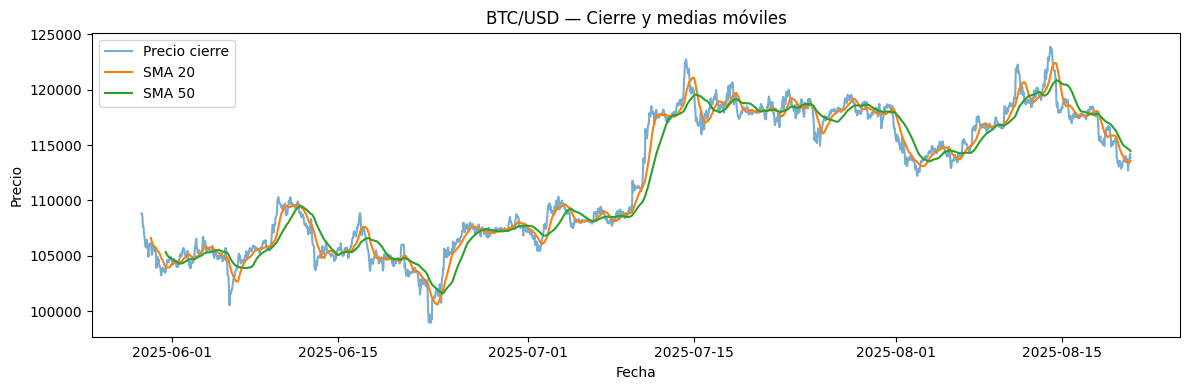

In [7]:
# Serie de precios + medias móviles
plt.figure(figsize=(12,4))
plt.plot(btc_df['timestamp'], btc_df['close'], label="Precio cierre", alpha=0.6)
plt.plot(btc_df['timestamp'], btc_df['close'].rolling(20).mean(), label="SMA 20")
plt.plot(btc_df['timestamp'], btc_df['close'].rolling(50).mean(), label="SMA 50")
plt.legend(); plt.title("BTC/USD — Cierre y medias móviles"); plt.xlabel("Fecha"); plt.ylabel("Precio"); plt.tight_layout(); plt.show()

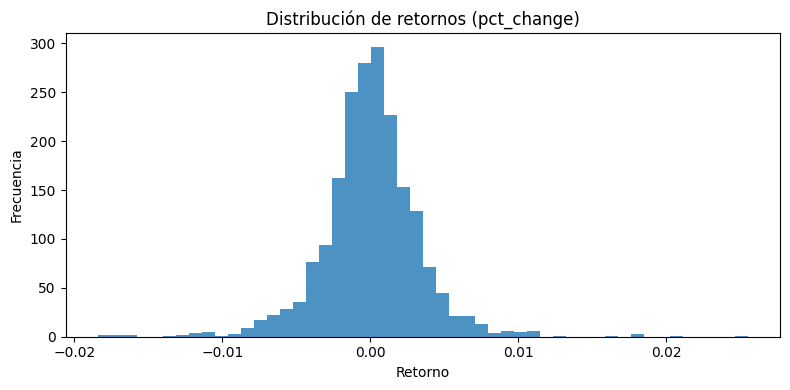

In [8]:
# Histograma de retornos y curva acumulada
returns = btc_df['close'].pct_change().dropna()
plt.figure(figsize=(8,4))
plt.hist(returns, bins=50, alpha=0.8)
plt.title("Distribución de retornos (pct_change)"); plt.xlabel("Retorno"); plt.ylabel("Frecuencia"); plt.tight_layout(); plt.show()

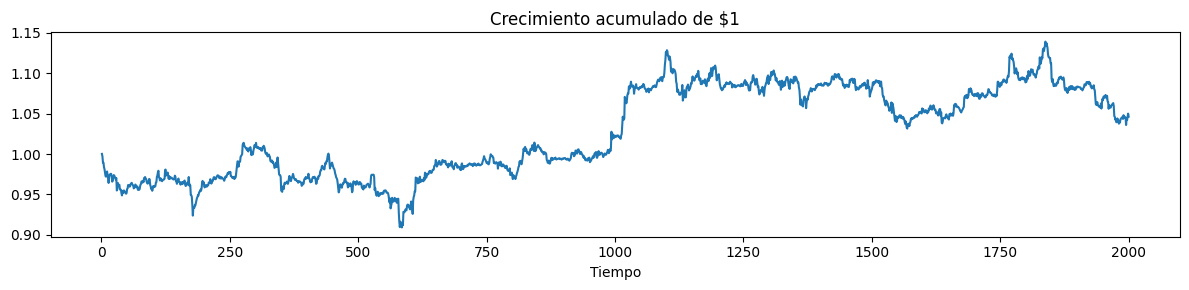

In [9]:
plt.figure(figsize=(12,3))
(1+returns).cumprod().plot()
plt.title("Crecimiento acumulado de $1"); plt.xlabel("Tiempo"); plt.tight_layout(); plt.show()

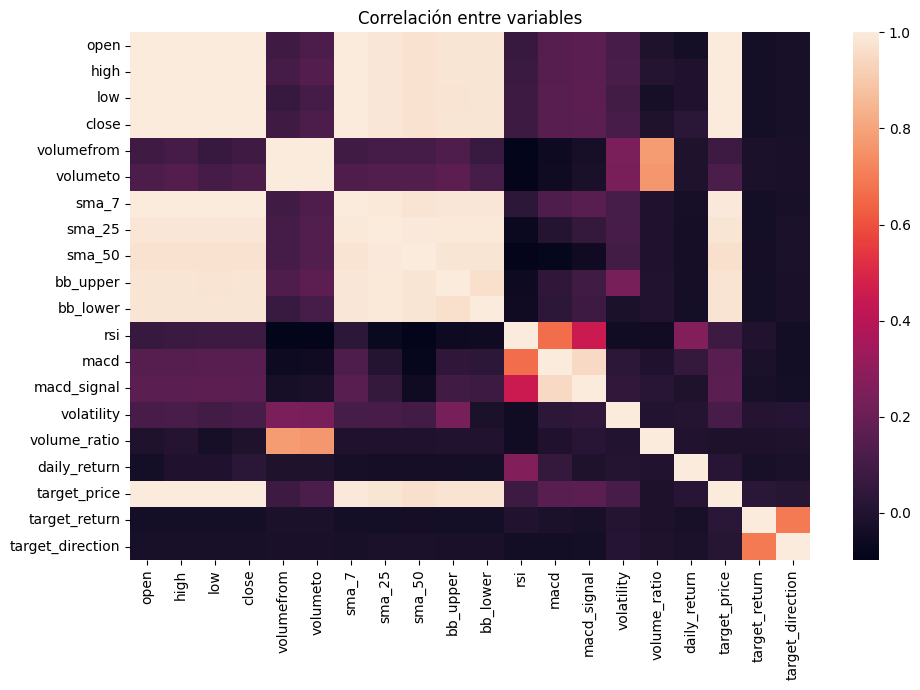

In [26]:
# Mapa de calor de correlaciones entre features ya construidas (si existen)
if 'features' in globals():
    corr = btc_df[features + ['target_price','target_return','target_direction']].corr(numeric_only=True)
    plt.figure(figsize=(10,7))
    sns.heatmap(corr, annot=False)
    plt.title("Correlación entre variables"); plt.tight_layout(); plt.show()

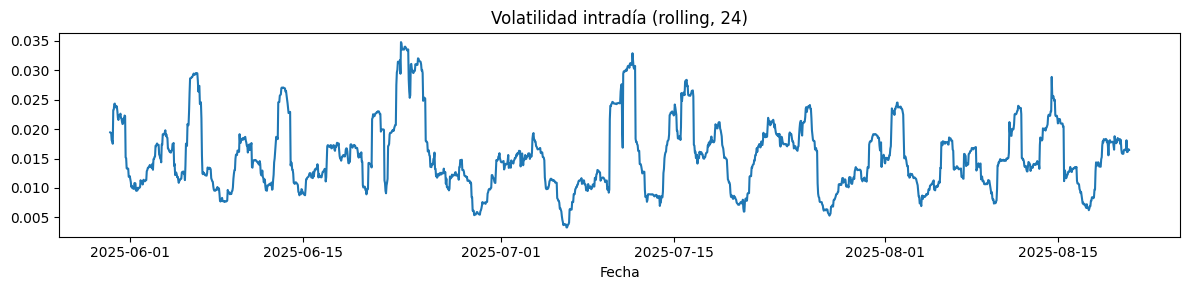

In [11]:
# Volatilidad rolling
vol = (np.log(btc_df['close']).diff().rolling(24).std()*np.sqrt(24)).dropna()
plt.figure(figsize=(12,3))
plt.plot(btc_df.loc[vol.index, 'timestamp'], vol)
plt.title("Volatilidad intradía (rolling, 24)"); plt.xlabel("Fecha"); plt.tight_layout(); plt.show()

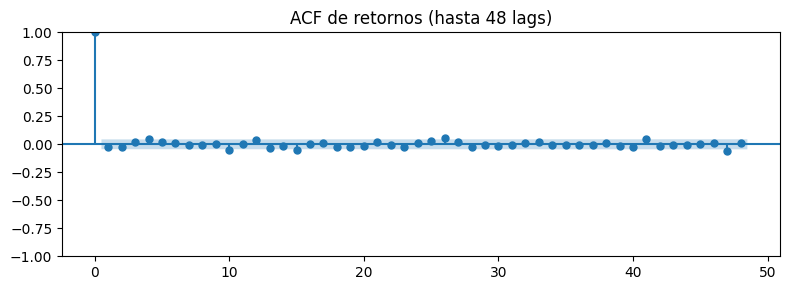

In [12]:
# ACF opcional (si statsmodels está disponible)
try:
    from statsmodels.graphics.tsaplots import plot_acf
    fig = plt.figure(figsize=(8,3))
    plot_acf(btc_df['close'].pct_change().dropna(), ax=plt.gca(), lags=48)
    plt.title("ACF de retornos (hasta 48 lags)"); plt.tight_layout(); plt.show()
except Exception as e:
    print("ACF omitido (instala statsmodels para verlo).")

🎯 RESUMEN VELA BTC:
📅 Fecha: 2025-05-29 10:00:00
💰 Apertura: $108,568.91
📈 Máximo: $108,902.66
📉 Mínimo: $108,441.17
🎯 Cierre: $108,796.70
📊 Volumen: 498.60 BTC ($54,168,298)
📏 Rango: $461.49
🔄 Cambio: +0.21%


0          NaN
1        16.64
2      -343.30
3      -832.24
4         1.95
         ...  
1996    782.47
1997   -115.91
1998    495.40
1999    368.07
2000   -404.23
Name: close, Length: 2001, dtype: float64

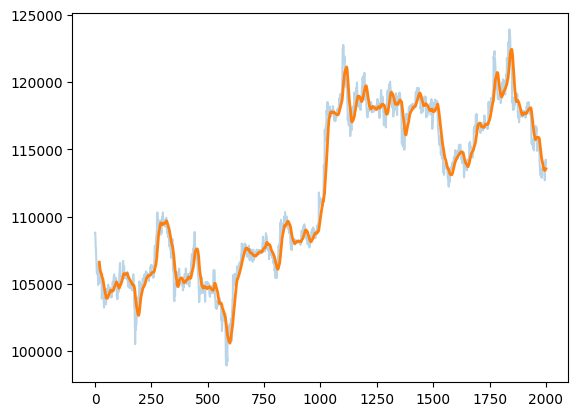

In [13]:
def print_resumen(fila):
    print("🎯 RESUMEN VELA BTC:")
    print("=" * 40)
    print(f"📅 Fecha: {fila['timestamp']}")
    print(f"💰 Apertura: ${fila['open']:,.2f}")
    print(f"📈 Máximo: ${fila['high']:,.2f}") 
    print(f"📉 Mínimo: ${fila['low']:,.2f}")
    print(f"🎯 Cierre: ${fila['close']:,.2f}")
    print(f"📊 Volumen: {fila['volumefrom']:,.2f} BTC (${fila['volumeto']:,.0f})")
    
    # Análisis adicional
    rango = fila['high'] - fila['low']
    cambio = ((fila['close'] - fila['open']) / fila['open']) * 100
    
    print(f"📏 Rango: ${rango:,.2f}")
    print(f"🔄 Cambio: {cambio:+.2f}%")

print_resumen(btc_df.iloc[0])

precios = btc_df['close'].values
plt.plot(precios, alpha=0.3, label='Precio Real (ruidoso)')

sma_20 = btc_df['close'].rolling(window=20).mean()
plt.plot(sma_20, linewidth=2, label='SMA 20 (suavizado)')
btc_df['close'].diff()

In [14]:
def crear_caracteristicas_tecnicas(df):
    """
    Crea indicadores técnicos para trading
    """
    # Precio de cierre como referencia
    df['price'] = df['close']
    
    # Medias móviles
    df['sma_7'] = df['close'].rolling(window=7).mean()    
    df['sma_25'] = df['close'].rolling(window=25).mean() 
    df['sma_50'] = df['close'].rolling(window=50).mean()  
    
    # Bandas de Bollinger
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp12 = df['close'].ewm(span=12, adjust=False).mean()
    exp26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp12 - exp26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Volatilidad
    df['volatility'] = df['close'].rolling(window=20).std()
    
    # Volume indicators
    df['volume_sma'] = df['volumefrom'].rolling(window=20).mean()
    df['volume_ratio'] = df['volumefrom'] / df['volume_sma']
    
    # Returns
    df['daily_return'] = df['close'].pct_change()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # Target: Precio futuro (1 periodo adelante)
    df['target_price'] = df['close'].shift(-1)
    df['target_return'] = df['daily_return'].shift(-1)
    df['target_direction'] = np.where(df['target_return'] > 0, 1, 0)  # 1=sube, 0=baja
    
    return df

### RSI (Relative Strength Index)

Qué es: Indicador de momentum que mide la fuerza relativa de las subidas frente a las bajadas en un periodo (típicamente 14 días).

Para qué sirve: Detecta condiciones de sobrecompra (>70) o sobreventa (<30), útil para anticipar cambios de tendencia.

Por qué sirve: Se basa en la lógica de que los precios no suben ni bajan indefinidamente sin corrección; cuando la fuerza compradora/vendedora se desequilibra demasiado, es más probable un giro.

### MACD (Moving Average Convergence Divergence)

Qué es: Diferencia entre dos medias móviles exponenciales (rápida de 12 y lenta de 26).

Para qué sirve: Identifica la dirección y fuerza de la tendencia. Cruces entre la línea MACD y su señal indican cambios de tendencia.

Por qué sirve: Combina información de corto y mediano plazo, capturando cuándo la tendencia gana o pierde impulso. El histograma refleja esa divergencia.

### Volatilidad

Qué es: Desviación estándar de los precios en una ventana de 20 periodos.

Para qué sirve: Mide el riesgo y la inestabilidad del activo; alta volatilidad implica movimientos bruscos y más incertidumbre.

Por qué sirve: En mercados financieros, la variabilidad pasada suele ser indicativa de posibles escenarios de riesgo en el corto plazo.

### Indicadores de volumen

Qué es: Media móvil del volumen y la relación volumen actual / volumen promedio.

Para qué sirve: Detecta acumulación/distribución. Si el volumen actual es mucho mayor que el promedio → el movimiento de precios tiene más credibilidad.

Por qué sirve: El volumen es una señal de validación: sin volumen, un cambio de precio puede ser ruido; con volumen, refleja convicción de mercado.

### Retornos

Qué es:

- daily_return: rendimiento porcentual simple entre dos días.

- log_return: rendimiento logarítmico, más usado en finanzas.

Para qué sirve: Normaliza las variaciones de precios para análisis estadístico, cálculo de riesgo, correlaciones y modelos predictivos.

Por qué sirve: Los rendimientos (no precios) tienden a ser más estacionarios, lo que facilita la modelación matemática.

### Targets (variables objetivo)

Qué es:

- target_price: el precio del siguiente periodo.

- target_return: el rendimiento del siguiente periodo.

- target_direction: la dirección futura (1=sube, 0=baja).

Para qué sirve: Son las etiquetas que los modelos intentan predecir (regresión → precio/retorno; clasificación → dirección).

Por qué sirve: Porpone una variable futura a partir de las actuales.

In [15]:
# Aplicar características técnicas
btc_df = crear_caracteristicas_tecnicas(btc_df)

# Eliminar filas con NaN (de las medias móviles)
btc_df = btc_df.dropna()

print(f"Dataset shape: {btc_df.shape}")
print(btc_df[['timestamp', 'close', 'sma_7', 'rsi', 'macd', 'target_direction']].head())

Dataset shape: (1951, 29)
             timestamp      close          sma_7        rsi        macd  \
49 2025-05-31 11:00:00  103551.23  103653.952857  32.985827 -539.016236   
50 2025-05-31 12:00:00  104087.06  103727.858571  51.093464 -474.347185   
51 2025-05-31 13:00:00  104174.44  103766.942857  52.106561 -411.304399   
52 2025-05-31 14:00:00  104627.03  103884.600000  58.649288 -321.120627   
53 2025-05-31 15:00:00  104612.19  104013.895714  67.100775 -247.988150   

    target_direction  
49                 1  
50                 1  
51                 1  
52                 0  
53                 0  


## 4) Ingeniería de características (resumen) <a id="features"></a>

- **Medias móviles**: `sma_7`, `sma_25`, `sma_50`.
- **Bandas de Bollinger**: `bb_upper`, `bb_lower`.
- **Momentum**: `rsi`, `macd`, `macd_signal`.
- **Riesgo**: `volatility` (desv. estándar rolling de log-returns).
- **Volumen**: `volume_sma`, `volume_ratio`.
- **Targets**: `target_price`, `target_return`, `target_direction`.

---

## 🧑‍🍳 Paso a paso del código

1. **Carga y ordenación de datos** (`cryptocompare` → `timestamp`).
2. **EDA básica** (serie de precios, retornos, correlación).
3. **Ingeniería** de indicadores técnicos y definición de **targets**.
4. **Escalado** de `features` y creación de **secuencias** (`window_size`) para LSTM.
5. **Modelos base** (RF, GB, XGB, LGBM + LSTM).
6. **Stacking**: se generan *meta-features* con las predicciones de los modelos base y se entrena el **meta-modelo**.
7. **Evaluación** en test (MAE de precio, accuracy de dirección) + **gráficos**.
8. **Predicción del próximo período** con `predict_next`.

In [16]:

# Seleccionar características para el modelo
features = [
    'open', 'high', 'low', 'close', 'volumefrom', 'volumeto',
    'sma_7', 'sma_25', 'sma_50', 'bb_upper', 'bb_lower', 'rsi',
    'macd', 'macd_signal', 'volatility', 'volume_ratio', 'daily_return'
]

targets = ['target_price', 'target_return', 'target_direction']

# Datos para el modelo
X = btc_df[features].values
y = btc_df[targets].values

# Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [17]:
# Crear secuencias temporales
def crear_secuencias_btc(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i + window_size])
        y_seq.append(y[i + window_size])  # Predecir el siguiente punto
    return np.array(X_seq), np.array(y_seq)

window_size = 30  # 30 periodos históricos
X_seq, y_seq = crear_secuencias_btc(X_scaled, y, window_size)

print(f"X_seq shape: {X_seq.shape}")  # (muestras, 30, 17 características)
print(f"y_seq shape: {y_seq.shape}")  # (muestras, 3 targets)

X_seq shape: (1921, 30, 17)
y_seq shape: (1921, 3)


## 5) Modelos que usaremos <a id="modelos"></a>

**Modelos base:**
- **Random Forest (RF):** *Bagging* de árboles. Robusto al ruido, maneja no linealidades, entrega **importancias de variables**.
- **Gradient Boosting (GB):** Ensambla árboles **en secuencia** minimizando el error residual.
- **XGBoost:** Variante optimizada de boosting con regularización.
- **LightGBM:** Boosting rápido/ligero con *leaf-wise growth*.
- **LSTM (2 redes):** Una para **precio/retorno** (regresión) y otra para **dirección** (clasificación). Capturan **dependencias temporales**.

**Meta-modelo (stacking):**
- **Regresión lineal** que aprende a combinar (apilar) las salidas de los modelos base para producir 3 objetivos: `target_price`, `target_return` y `target_direction`.

# 📘 Ensambladores en Machine Learning  

## 🔹 ¿Qué son?  
Los **ensambladores** son técnicas que **combinan múltiples modelos** (llamados **modelos base** o *learners*) para producir un **modelo final más robusto y preciso**.  

La idea es simple:  
> *“Un conjunto de modelos débiles puede formar un modelo fuerte si se combinan bien”*.  

Ejemplo intuitivo: si le preguntas a 10 expertos sobre el precio de Bitcoin mañana, es probable que el **promedio de sus predicciones sea mejor** que la de un solo experto.  

---

## 🔹 ¿Por qué sirven?  
- ✅ Reducen el **sesgo (bias)** → corrigen errores sistemáticos.  
- ✅ Reducen la **varianza** → evitan sobreajuste.  
- ✅ Mejoran la **generalización** → más estables en datos nuevos.  
- ✅ **Capturan diferentes aspectos** del problema → modelos distintos aportan diferentes fortalezas.  

---

## 🔹 Tipos principales de ensambladores  

### 1. **Bagging (Bootstrap Aggregating)** 👜  
- Entrena varios modelos en **muestras diferentes** del dataset (con reemplazo).  
- Se promedian (regresión) o se votan (clasificación).  
- Ejemplo: **Random Forest**.  
- ✅ Reduce **varianza**.  

---

### 2. **Boosting** ⚡  
- Entrena modelos de forma **secuencial**.  
- Cada modelo nuevo se enfoca en **corregir los errores** del anterior.  
- Ejemplo: **XGBoost, LightGBM, AdaBoost**.  
- ✅ Reduce **sesgo** y mejora exactitud.  

---

### 3. **Stacking (Stacked Generalization)** 🏗️  
- Combina predicciones de distintos modelos (árboles, regresiones, redes, etc.).  
- Un **meta-modelo** aprende a mezclar esas predicciones para dar la final.  
- ✅ Muy flexible, aprovecha lo mejor de cada algoritmo.  

---

### 4. **Voting** 🗳️  
- Combina modelos de forma simple:  
  - **Hard Voting**: mayoría de votos (clasificación).  
  - **Soft Voting**: promedio de probabilidades.  
- Ejemplo: un comité de modelos decide la clase final.  

---

## 🔹 Ejemplo en predicción de BTC  
- **Bagging (Random Forest)**: analiza muchos árboles de decisión para reducir ruido en la serie.  
- **Boosting (XGBoost, LightGBM)**: capta relaciones no lineales en retornos y volatilidad.  
- **Stacking**: combina Random Forest + XGBoost + Regresión Logística para predecir dirección del precio.  
- **Voting**: decide entre modelos simples (SVM, Árboles, Regresión) por mayoría.  

---

👉 En resumen:  
Los **ensambladores son como un equipo de traders con diferentes estrategias**; juntos suelen ser más consistentes que un trader aislado.  


## 7) Clase `TradingEnsemble` (arquitectura y uso) <a id="tradingensemble"></a>

**Arquitectura resumida:**
1. **Modelos base (paralelo):** RF, GB, XGBoost, LightGBM sobre *features 2D* (OHLCV+indicadores) y dos LSTM sobre **secuencias** (*ventana temporal*).
2. **Meta-features:** concatenamos: predicciones de (RF, GB, XGB, LGBM) + salidas de las LSTM.
3. **Meta-modelo:** Regresión lineal (multi-salida) que aprende pesos óptimos por objetivo.
4. **Predicción final:** `predict_ensemble(X_2d, X_seq)` devuelve `[precio, retorno, dirección_prob]`.

**Uso básico:**
```python
trading_ensemble = TradingEnsemble(window_size=30, n_features=len(features))
trading_ensemble.initialize_models()
trading_ensemble.prepare_ensemble_data(btc_df, features, targets)  # split + escalado + secuencias
trading_ensemble.train_ensemble()                                  # entrena base + meta
metrics = trading_ensemble.evaluate_ensemble()                     # métricas
```

In [18]:
class TradingEnsemble:
    def __init__(self, window_size=30, n_features=17):
        self.window_size = window_size
        self.n_features = n_features
        self.models = {}
        self.scaler = MinMaxScaler()
        self.is_fitted = False
    
    def initialize_models(self):
        """Inicializa todos los modelos del ensemble"""
        # 1. Tree-based models
        self.models['xgb'] = MultiOutputRegressor(XGBRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
        ))
        
        self.models['lgbm'] = MultiOutputRegressor(LGBMRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
        ))
        
        self.models['rf'] = MultiOutputRegressor(RandomForestRegressor(
            n_estimators=100, max_depth=10, random_state=42
        ))
        
        self.models['gboost'] = MultiOutputRegressor(GradientBoostingRegressor(
            n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42
        ))
        
        # 2. Neural Networks
        self.models['lstm_price'] = self._create_lstm_model(2) 
        self.models['lstm_direction'] = self._create_lstm_classifier()
        
        # 3. Meta-model for stacking
        self.meta_model = MultiOutputRegressor(LinearRegression())
        
    def _create_lstm_model(self, output_dim):
        """Crea modelo LSTM para regresión"""
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(self.window_size, self.n_features)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(50),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model
    
    def _create_lstm_classifier(self):
        """Crea modelo LSTM para clasificación"""
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(self.window_size, self.n_features)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def prepare_ensemble_data(self, btc_df, features, targets):
        """
        Prepara datos para todos los modelos del ensemble
        """

        X = btc_df[features].values
        y = btc_df[targets].values
        
        X_scaled = self.scaler.fit_transform(X)

        X_seq, y_seq = self._create_sequences(X_scaled, y)
        
        X_2d = X_scaled[self.window_size:] 
        
        split_idx = int(len(X_seq) * 0.8)
        
        self.X_train_seq = X_seq[:split_idx]
        self.X_test_seq = X_seq[split_idx:]
        self.y_train_seq = y_seq[:split_idx]
        self.y_test_seq = y_seq[split_idx:]
        
        self.X_train_2d = X_2d[:split_idx]
        self.X_test_2d = X_2d[split_idx:]
        self.y_train_2d = y_seq[:split_idx]
        self.y_test_2d = y_seq[split_idx:]
        
        return True

    def _create_sequences(self, X, y):
        """Crea secuencias temporales"""
        X_seq, y_seq = [], []
        for i in range(len(X) - self.window_size):
            X_seq.append(X[i:i + self.window_size])
            y_seq.append(y[i + self.window_size])
        return np.array(X_seq), np.array(y_seq)
    
    def train_ensemble(self):
        """Entrena todos los modelos del ensemble"""
        print("🏗️ Entrenando ensemble de trading...")
        
        # 1. Entrenar tree models
        for name, model in self.models.items():
            if name in ['xgb', 'lgbm', 'rf', 'gboost']:
                print(f"Entrenando {name}...")
                model.fit(self.X_train_2d, self.y_train_2d)

        # 2. Entrenar LSTM models
        print("Entrenando LSTM price...")
        self.models['lstm_price'].fit(
            self.X_train_seq, self.y_train_seq[:, :2],
            epochs=100, batch_size=32, validation_split=0.2, verbose=0
        )
        
        print("Entrenando LSTM direction...")
        self.models['lstm_direction'].fit(
            self.X_train_seq, self.y_train_seq[:, 2],  
            epochs=100, batch_size=32, validation_split=0.2, verbose=0
        )
        
        # 3. Crear meta-features para stacking
        print("Creando meta-features...")
        X_meta_train = self._create_meta_features(self.X_train_2d, self.X_train_seq)
        X_meta_test = self._create_meta_features(self.X_test_2d, self.X_test_seq)
        
        # 4. Entrenar meta-modelo
        print("Entrenando meta-modelo...")
        self.meta_model.fit(X_meta_train, self.y_train_2d)
        
        self.is_fitted = True
        print("✅ Ensemble entrenado exitosamente!")

        # DEBUG: Mostrar coeficientes inmediatamente después
        print("✅ Coeficientes calculados:")
        for i, target in enumerate(['precio', 'retorno', 'dirección']):
            coef = self.meta_model.estimators_[i].coef_
            intercept = self.meta_model.estimators_[i].intercept_
            print(f"🎯 {target}: intercept={intercept:.4f}, coef={coef}")

    def _create_meta_features(self, X_2d, X_seq):
        """Crea meta-features de todas las predicciones"""
        meta_features = []
        
        # Predicciones de tree models
        for name, model in self.models.items():
            if name in ['xgb', 'lgbm', 'rf', 'gboost']:
                pred = model.predict(X_2d)
                meta_features.append(pred)
        
        # Predicciones de LSTM
        lstm_price_pred = self.models['lstm_price'].predict(X_seq)
        lstm_dir_pred = self.models['lstm_direction'].predict(X_seq)
        
        # Combinar predicciones LSTM
        lstm_combined = np.column_stack([lstm_price_pred, lstm_dir_pred])
        meta_features.append(lstm_combined)

        return np.hstack(meta_features)


    def predict_ensemble(self, X_2d, X_seq):
        """Predice usando todo el ensemble"""
        if not self.is_fitted:
            raise ValueError("Ensemble no está entrenado. Llama a train_ensemble() primero.")
        
        # 1. Obtener meta-features
        X_meta = self._create_meta_features(X_2d, X_seq)
        
        # 2. Predecir con meta-modelo
        ensemble_pred = self.meta_model.predict(X_meta)
        
        return ensemble_pred

    def predict_proba_direction(self, X_seq):
        """Predice probabilidad de dirección (especializado)"""
        return self.models['lstm_direction'].predict(X_seq)

    def predict_next(self, recent_data):
        """Predice el próximo período"""
        # Preparar datos recientes
        recent_scaled = self.scaler.transform(recent_data)
        
        # Crear secuencia
        if len(recent_scaled) < self.window_size:
            raise ValueError(f"Se necesitan {self.window_size} períodos, se tienen {len(recent_scaled)}")
        
        X_seq = recent_scaled[-self.window_size:].reshape(1, self.window_size, self.n_features)
        X_2d = recent_scaled[-1:].reshape(1, -1)
        
        # Predecir
        prediction = self.predict_ensemble(X_2d, X_seq)
        direction_proba = self.predict_proba_direction(X_seq)[0][0]
        
        return {
            'predicted_price': prediction[0][0],
            'predicted_return': prediction[0][1],
            'direction_probability': direction_proba,
            'direction': 'UP' if direction_proba > 0.5 else 'DOWN'
        }

    def evaluate_ensemble(self):
        """Evalúa todo el ensemble"""
        if not self.is_fitted:
            raise ValueError("Ensemble no está entrenado")
        
        # Predecir en test
        ensemble_pred = self.predict_ensemble(self.X_test_2d, self.X_test_seq)
        
        # Métricas para regresión (price + return)
        mae_price = mean_absolute_error(self.y_test_2d[:, 0], ensemble_pred[:, 0])
        mae_return = mean_absolute_error(self.y_test_2d[:, 1], ensemble_pred[:, 1])
        
        # Métrica para clasificación (direction)
        pred_direction = (ensemble_pred[:, 2] > 0.5).astype(int)
        accuracy = accuracy_score(self.y_test_2d[:, 2], pred_direction)
        
        # Métricas individuales
        individual_metrics = self._evaluate_individual_models()
        
        return {
            'ensemble': {
                'price_mae': mae_price,
                'return_mae': mae_return,
                'direction_accuracy': accuracy
            },
            'individual': individual_metrics
        }

    def _evaluate_individual_models(self):
        """Evalúa cada modelo individualmente"""
        metrics = {}
        
        # Evaluar tree models
        for name, model in self.models.items():
            if name in ['xgb', 'lgbm', 'rf', 'gboost']:
                pred = model.predict(self.X_test_2d)
                mae = mean_absolute_error(self.y_test_2d[:, 0], pred[:, 0])
                metrics[name] = {'price_mae': mae}
        
        # Evaluar LSTM
        lstm_price_pred = self.models['lstm_price'].predict(self.X_test_seq)
        lstm_mae = mean_absolute_error(self.y_test_seq[:, 0], lstm_price_pred[:, 0])
        metrics['lstm_price'] = {'price_mae': lstm_mae}
        
        lstm_dir_pred = self.models['lstm_direction'].predict(self.X_test_seq)
        lstm_acc = accuracy_score(self.y_test_seq[:, 2], (lstm_dir_pred > 0.5).astype(int))
        metrics['lstm_direction'] = {'accuracy': lstm_acc}
        
        return metrics
    
    def get_meta_weights(self):
        """Muestra los pesos aprendidos por el meta-modelo"""
        if not self.is_fitted:
            raise ValueError("Meta-modelo no entrenado")
        
        # Obtener nombres de las meta-features
        feature_names = []
        for name in ['xgb', 'lgbm', 'rf', 'gboost']:
            feature_names.extend([f'{name}_price', f'{name}_return'])
        
        feature_names.extend(['lstm_price', 'lstm_return', 'lstm_direction'])
        
        # Obtener pesos del meta-modelo
        weights = self.meta_model.estimators_[0].coef_  # Para la primera salida (precio)
        
        return dict(zip(feature_names, weights))

    def debug_meta_features(self, n_samples=3):
        """Muestra ejemplos reales de X_meta_train"""
        X_meta = self._create_meta_features(self.X_train_2d, self.X_train_seq)
        
        print("🔍 X_meta_train - Primeras", n_samples, "muestras:")
        print("=" * 100)
        
        feature_names = [
            'xgb_price', 'xgb_return', 'lgbm_price', 'lgbm_return',
            'rf_price', 'rf_return', 'gboost_price', 'gboost_return', 
            'lstm_price', 'lstm_return', 'lstm_direction'
        ]
        
        for i in range(n_samples):
            print(f"\n📊 MUESTRA {i + 1}:")
            print("-" * 50)
            
            for j, (name, value) in enumerate(zip(feature_names, X_meta[i])):
                if 'price' in name:
                    formatted = f"${value:,.2f}"
                elif 'return' in name:
                    formatted = f"{value:.3%}"
                elif 'direction' in name:
                    formatted = f"{value:.1%}"
                else:
                    formatted = f"{value:.4f}"
                
                print(f"{name:15}: {formatted}")

In [19]:

# Inicializar ensemble
trading_ensemble = TradingEnsemble(window_size=30, n_features=len(features))
trading_ensemble.initialize_models()

# Preparar datos
trading_ensemble.prepare_ensemble_data(btc_df, features, targets)

# Entrenar
trading_ensemble.train_ensemble()

# Evaluar
metrics = trading_ensemble.evaluate_ensemble()
print("📊 Métricas del Ensemble:")
print(f"MAE Precio: {metrics['ensemble']['price_mae']:.4f}")
print(f"Accuracy Dirección: {metrics['ensemble']['direction_accuracy']:.3f}")

# Predecir próximo período
ultimos_datos = btc_df[features].tail(30)
prediccion = trading_ensemble.predict_next(ultimos_datos)

print(f"\n🎯 Predicción Próximo Período:")
print(f"Precio estimado: ${prediccion['predicted_price']:,.2f}")
print(f"Probabilidad subida: {prediccion['direction_probability']:.3f}")
print(f"Dirección: {prediccion['direction']}")


E0000 00:00:1755713175.547386     887 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1755713175.567010     887 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🏗️ Entrenando ensemble de trading...
Entrenando xgb...
Entrenando lgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 17
[LightGBM] [Info] Start training from score 110822.782313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 7/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Entrenando meta-modelo...
✅ Ensemble entrenado exitosamente!
✅ Coeficientes calculados:
🎯 precio: intercept=-26036761.1964, coef=[ 9.53219855e-01  6.00614235e+04  2.13078140e+02 -1.32434416e-01
 -1.80760932e+04 -1.05504433e+02  5.62847953e-01 -1.37927331e+04
  3.20883127e+01 -3.85979494e-01 -3.04832989e+04 -1.83341391e+02
  9.55437505e+02 -2.61252443e+01  5.39392659e+00]
🎯 retorno: intercept=298.7504, coef=[ 3.02652060e-06  1.56573099e+00  2.79741535e-03 -2.59348771e-06
 -1.81178960e-02 -1.05846105e-03  3.55647108e-06 -7.41217297e-02
  2.32567029e-04 -4.01596179e-06 -5.05833559e-01 -2.64750820e-03
 -1.09626158e-02  2.99759025e-04 -3.14871921e-04]
🎯 dirección: intercept=296865.3526, coef=[ 4.05587464e-05  2.94922065e+01  1.78092404e+00 -1.27665778e-04
 -2.51151168e+01 -1.51156035e-01  2.59586107e-04 -3.85861641e+00
  4.13493611e-01 -1.73168365e-04 -2.51519311e+01 -7.82571128e-01
 -1.08935695e+01  2.97871042e

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 6/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
📊 Métricas del Ensemble:
MAE Precio: 412.1699
Accuracy Dirección: 0.473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🎯 Predicción Próximo Período:
Precio estimado: $114,014.08
Probabilidad subida: 0.503
Dirección: UP


In [24]:
weights = trading_ensemble.get_meta_weights()
print(weights)

{'xgb_price': np.float64(0.953219854917764), 'xgb_return': np.float64(60061.42347931533), 'lgbm_price': np.float64(213.07814026947128), 'lgbm_return': np.float64(-0.13243441552185686), 'rf_price': np.float64(-18076.0931729538), 'rf_return': np.float64(-105.50443265704133), 'gboost_price': np.float64(0.5628479532970232), 'gboost_return': np.float64(-13792.733070578113), 'lstm_price': np.float64(32.08831272203132), 'lstm_return': np.float64(-0.38597949362156214), 'lstm_direction': np.float64(-30483.298942708312)}


In [25]:
trading_ensemble.debug_meta_features()

 7/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
🔍 X_meta_train - Primeras 3 muestras:

📊 MUESTRA 1:
--------------------------------------------------
xgb_price      : $105,126.28
xgb_return     : -0.001%
lgbm_price     : $0.19
lgbm_return    : 10515052.353%
rf_price       : $0.00
rf_return      : 36.280%
gboost_price   : $105,012.79
gboost_return  : 0.014%
lstm_price     : $0.44
lstm_return    : 10512441.236%
lstm_direction : 0.0%

📊 MUESTRA 2:
--------------------------------------------------
xgb_price      : $105,067.52
xgb_return     : 0.098%
lgbm_price     : $0.91
lgbm_return    : 10505532.885%
rf_price       : $0.00
rf_return      : 58.854%
gboost_price   : $105,053.81
gboost_return  : 0.009%
lstm_price     : $0.60
lstm_return    : 10496964.517%
lstm_direction : 0.0%

📊 MUESTRA 3:
--------------------------------------------------
xgb_price      : $105,127.45
xgb_return     : 0.017%
lgbm_price     : $0.20
lgbm_return    : 10515330.111%
rf_price     

## 8) Entrenamiento, evaluación y gráficos <a id="training"></a>

A continuación se muestran **gráficos listos para presentar**: predicción vs real, residuales, matriz de confusión de la dirección y **importancia de variables** (árboles).

 5/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/vnton/.cache/pypoetry/virtualenvs/pronosticos-project-WF_HRN70-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


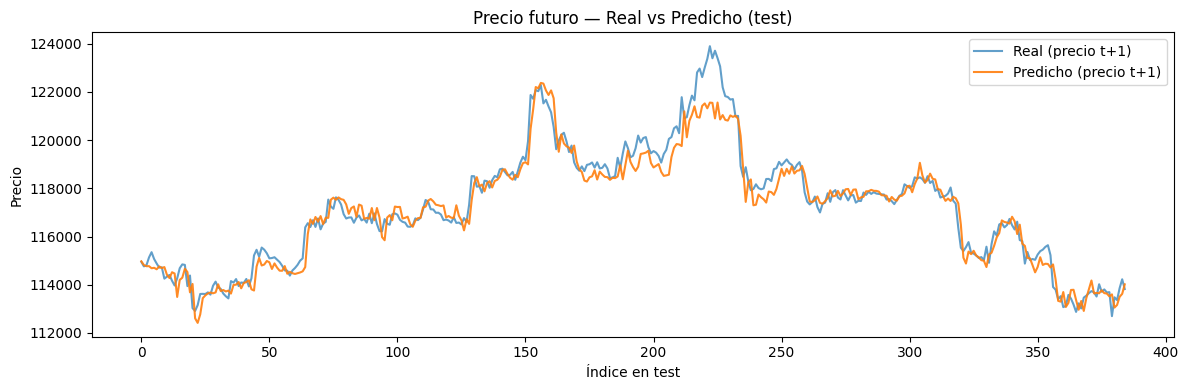

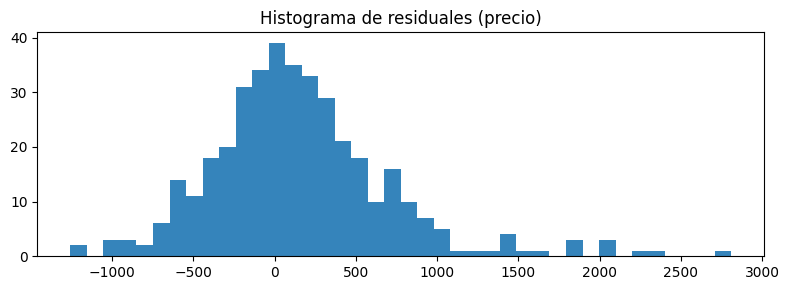

MAE test (precio): 412.1699
Accuracy dirección (test): 0.473

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0      0.476     0.469     0.473       194
         1.0      0.469     0.476     0.473       191

    accuracy                          0.473       385
   macro avg      0.473     0.473     0.473       385
weighted avg      0.473     0.473     0.473       385



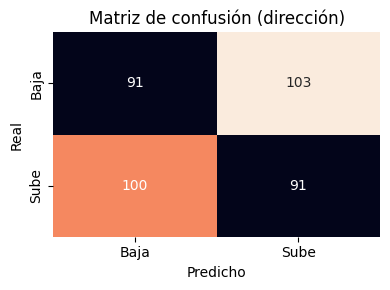

In [22]:
# Pred vs Real (conjunto de test)
y_pred = trading_ensemble.predict_ensemble(trading_ensemble.X_test_2d, trading_ensemble.X_test_seq)
y_true = trading_ensemble.y_test_2d  # precio/retorno/dirección

plt.figure(figsize=(12,4))
plt.plot(y_true[:,0], label="Real (precio t+1)", alpha=0.7)
plt.plot(y_pred[:,0], label="Predicho (precio t+1)", alpha=0.9)
plt.title("Precio futuro — Real vs Predicho (test)")
plt.xlabel("Índice en test"); plt.ylabel("Precio"); plt.legend(); plt.tight_layout(); plt.show()

# Residuales
res = y_true[:,0] - y_pred[:,0]
plt.figure(figsize=(8,3))
plt.hist(res, bins=40, alpha=0.9)
plt.title("Histograma de residuales (precio)"); plt.tight_layout(); plt.show()

# Métricas adicionales
mae = mean_absolute_error(y_true[:,0], y_pred[:,0])
print(f"MAE test (precio): {mae:.4f}")

# Clasificación de dirección
y_prob = y_pred[:,2]
y_hat = (y_prob > 0.5).astype(int)
acc = accuracy_score(y_true[:,2], y_hat)
print(f"Accuracy dirección (test): {acc:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_true[:,2], y_hat, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_true[:,2], y_hat)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["Baja","Sube"], yticklabels=["Baja","Sube"])
plt.title("Matriz de confusión (dirección)"); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout(); plt.show()

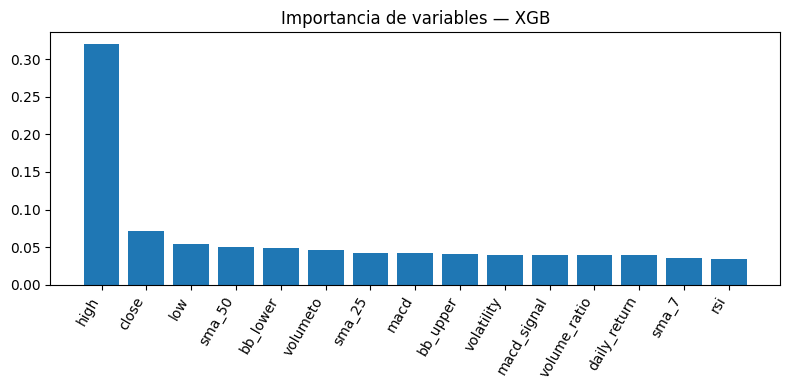

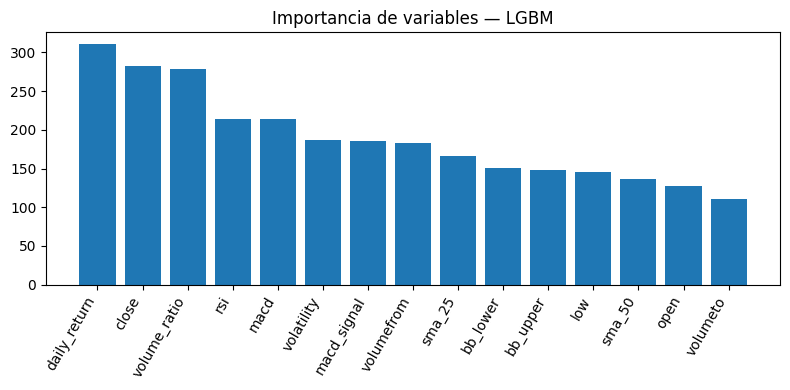

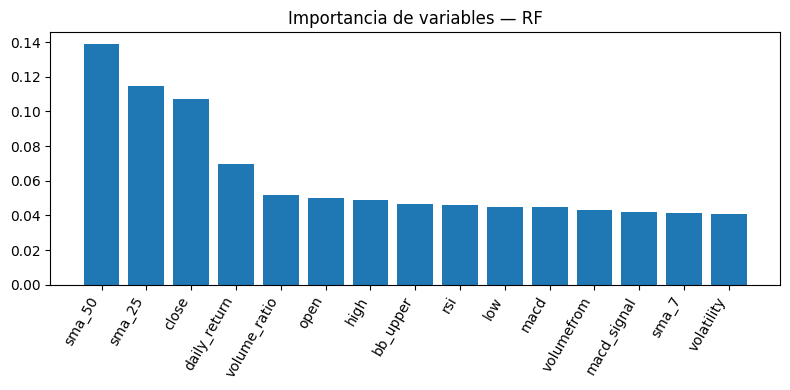

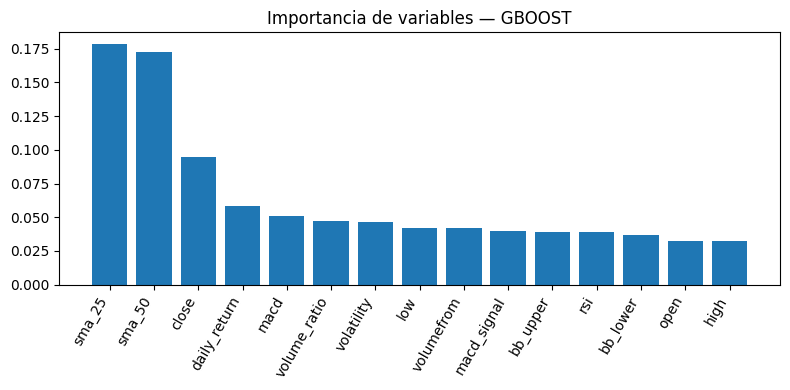

In [23]:
# Importancia de variables (promedio en salidas) para modelos de árboles
def avg_feature_importances(multi_out_estimator, feature_names):
    # multi_out_estimator es MultiOutputRegressor; promediamos importancias
    imps = []
    for est in multi_out_estimator.estimators_:
        if hasattr(est, "feature_importances_"):
            imps.append(est.feature_importances_)
    if not imps:
        return None
    return np.mean(np.vstack(imps), axis=0)

tree_models = {k:v for k,v in trading_ensemble.models.items() if k in ["rf","gboost","xgb","lgbm"]}
for name, model in tree_models.items():
    try:
        importances = avg_feature_importances(model, features)
        if importances is None: 
            print(f"{name}: sin importancias disponibles.")
            continue
        order = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(8,4))
        plt.bar(range(len(order)), importances[order])
        plt.xticks(range(len(order)), [features[i] for i in order], rotation=60, ha="right")
        plt.title(f"Importancia de variables — {name.upper()}"); plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"No se pudo calcular importancias para {name}: {e}")

## 9) Conclusiones y próximos pasos <a id="conclusiones"></a>

- El **ensemble apilado** mejora la robustez al combinar señales de **árboles** y **LSTM**.
- Añade **validación temporal** (backtesting *rolling* o *walk-forward*), *tuning* por `Optuna` y **regularización** para el meta-modelo.
- Considera *features* adicionales (órdenes limit, *order book*, *on-chain*, *sentiment*).
- **Uso responsable:** los resultados son demostrativos; no constituyen consejo financiero.